### **Table of Contents**
    
* [Error Handling](#error-handling)
* [Exploration and Cleaning](#exploration-and-cleaning)
  * [EDA Function](#eda-function)
  * [K Count](#k-count)
  * [HUD](#hud)
* [Keep this file in your project](#keep-this-file-in-your-project)

In [1]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from highlight_text import ax_text
from cycler import cycler
import numpy as np
from __future__ import annotations
from pathlib import Path
from typing import Dict, Union, Optional

# Error Handling

In [2]:


def read_excel_strict(
    filepath: Union[str, Path],
    sheet_name: Optional[Union[str, int]] = 0,
    **kwargs
) -> Union[pd.DataFrame, Dict[str, pd.DataFrame]]:
    """
    Read an Excel file with predictable behavior and no side effects.

    - Raises:
        FileNotFoundError: if the file path doesn't exist.
        ValueError: if pandas cannot read the file or returns an empty result.
    - Returns:
        - DataFrame when `sheet_name` is a name/index.
        - dict[str, DataFrame] when `sheet_name=None`.

    Notes:
        Keep this function 'pure' (no prints). Let callers decide how to log/print.
    """
    path = Path(filepath)
    if not path.exists():
        raise FileNotFoundError(f"Excel file not found: {path}")

    # Let pandas choose the engine; forward user kwargs like header=, dtype=, etc.
    result = pd.read_excel(path, sheet_name=sheet_name, **kwargs)

    if sheet_name is None:
        if not isinstance(result, dict) or len(result) == 0:
            raise ValueError(f"No sheets returned from: {path}")
        # Normalize keys to strings for consistency
        return {str(k): v for k, v in result.items()}

    if not isinstance(result, pd.DataFrame) or result.empty:
        raise ValueError(f"Empty or invalid DataFrame from: {path}, sheet={sheet_name}")

    return result

# Cleaning

## K Count Data

In [3]:
def read_kcount(filepath: str) -> pd.DataFrame:
    """
    Read and clean Kentucky KCount Excel data.

    Steps:
    1. Read Excel file (starting on row 2).
    2. Remove rows without a county name.
    3. Standardize and clean column names.
    4. Drop duplicate or redundant columns.
    5. Rename columns for clarity.
    6. Convert numeric columns to numeric dtype.
    7. Remove summary rows ("Kentucky", "Balance of State").
    8. Reset index.
    """
    # Read Excel
    df = read_excel_strict(filepath, header=2)

    # 2Remove rows without a county name
    df = df[df["County"].notna()].copy()

    # Clean column names (strip, remove spaces & symbols)
    df.columns = (
        df.columns
        .str.strip()
        .str.replace(r"\s+", "_", regex=True)
        .str.replace(r"[\*\(\)]", "", regex=True)
    )

    # Drop duplicate columns
    df = df.drop(columns=["Total_Number_of_persons.1", "Total_Number_of_persons.2"], errors="ignore")

    # Rename long columns
    rename_map = {
        "County": "county",
        "KY_Balance_of_State_CoC_Region": "coc_region",
        "KY_Area_Development_District_Balance_of_State_Coordinated_Entry_Local_Prioritization_Community": "add_region",
        "Total_Homeless": "total_homeless",
        "Population_Estimates_2024_most_recent_available_in_2025": "population_2024",
        "Percentage_of_Population": "percent_of_population",
        "Total_Number_of_persons": "total_persons",
        "Total_Number_of_Veterans": "veterans",
        "Total_Number_of_Chronically_Homeless_Persons": "chronically_homeless",
        "Adults_with_Serious_Mental_Illness_self-reported": "serious_mental_illness",
        "Adults_with_a_Substance_Use_Disorder_self-reported": "substance_use_disorder",
        "Adults_with_HIV/AIDS_self-reported": "hiv_aids",
        "Adults_whose_current_episode_of_homelessness_caused_by_domestic_violence_self-reported": "domestic_violence",
    }
    df = df.rename(columns=rename_map)

    # Convert numeric columns to numeric
    numeric_cols = df.select_dtypes(include="number").columns
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

    # Remove summary rows (state-level totals)
    df = df[~df["county"].isin(["Kentucky", "Balance of State"])]

    # Reset index
    df = df.reset_index(drop=True)

    return df


In [4]:
kcount_df = read_kcount("../ashley/data/k_count.xlsx")

## HUD

In [5]:
def read_hud(filepath: str) -> pd.DataFrame:
    """
    Read and clean HUD Excel data across multiple sheets.

    Steps:
    1. Read all sheets from Excel (each sheet = a year).
    2. Add 'year' column to each sheet.
    3. Concatenate all years into a single DataFrame.
    4. Remove footnote rows (non–2-letter state abbreviations).
    5. Normalize column names.
    6. Convert numeric columns to numeric dtypes.
    7. Drop columns with >30% missing data.
    8. Filter to Kentucky ('KY') only.
    9. Reset index and return cleaned DataFrame.
    """
    # Read all sheets
    hud_sheets = read_excel_strict(filepath, sheet_name=None, header=1)

    # Add 'year' column for each sheet and combine
    hud_list = []
    for year, df in hud_sheets.items():
        df = df.copy()
        df["year"] = str(year)
        hud_list.append(df)

    # Concatenate
    hud_all = pd.concat(hud_list, ignore_index=True)

    # Remove footnote rows and keep only 2-letter states
    hud_all = hud_all[hud_all["State"].str.len() == 2].copy()

    # Normalize column names
    hud_all.columns = (
        hud_all.columns
        .str.strip()
        .str.replace(r"\s+", "_", regex=True)
        .str.replace(r"[\(\)\n]", "", regex=True)
        .str.replace(r"[^A-Za-z0-9_]+", "", regex=True)
        .str.lower()
    )

    # Convert numeric columns
    non_numeric = ["state", "continuum_of_care_coc", "hud_coc_number", "ahar_part_1_coc_category"]
    numeric_cols = [c for c in hud_all.columns if c not in non_numeric]
    hud_all[numeric_cols] = hud_all[numeric_cols].apply(pd.to_numeric, errors="coerce")

    # Drop columns with >30% missing
    threshold = len(hud_all) * 0.7
    hud_all = hud_all.dropna(thresh=threshold, axis=1)

    # Filter for Kentucky
    hud_ky = hud_all[hud_all["state"] == "KY"].copy()

    # Reset index
    hud_ky = hud_ky.reset_index(drop=True)

    return hud_ky


# Plots

## Functions

In [6]:
formatter = mticker.StrMethodFormatter("{x:,.0f}")

def _is_number(s):
    """Helper to check if string can be converted to float."""
    try:
        float(s.replace(',', ''))  # remove commas if already formatted
        return True
    except ValueError:
        return False

def apply_formatter(ax=None):
    """Automatically format numeric axes with commas, leave text/categorical axes alone."""
    if ax is None:
        ax = plt.gca()
    
    # Format x-axis only if tick labels are numbers
    x_labels = [lbl.get_text() for lbl in ax.get_xticklabels()]
    if all(_is_number(lbl) for lbl in x_labels):
        ax.xaxis.set_major_formatter(formatter)
    
    # Format y-axis only if tick labels are numbers
    y_labels = [lbl.get_text() for lbl in ax.get_yticklabels()]
    if all(_is_number(lbl) for lbl in y_labels):
        ax.yaxis.set_major_formatter(formatter)

## Highest Homeless Population by County

In [7]:
def plot_top10_counties(df: pd.DataFrame, output_path: str = "../ashley/plots/top10_homeless_counties.png") -> None:
    """
    Plot the Top 10 Kentucky counties by total homeless population.

    Args:
        df (pd.DataFrame): Cleaned KCount DataFrame containing 'county' and 'total_homeless' columns.
        output_path (str): Path to save the PNG file.

    Returns:
        None (saves a PNG plot and shows it).
    """

    # Validate columns
    required = {"county", "total_homeless"}
    if not required.issubset(df.columns):
        raise ValueError(f"Missing required columns: {required - set(df.columns)}")

    # Style setup
    colors = ['#FEBE10', '#1D1E9E', '#AD0000', '#000000', '#FFFFFF']
    plt.rcParams.update({
        'axes.prop_cycle': cycler('color', colors),
        'figure.facecolor': 'lightgrey',
        'axes.facecolor': 'lightgrey',
        'axes.grid': True,
        'grid.color': '#000000',
        'grid.alpha': 0.1,
        'grid.linestyle': '--',
        'font.family': 'DejaVu Sans',
        'text.color': '#000000',
        'axes.labelcolor': '#000000',
        'axes.edgecolor': '#000000'
    })

    # Axis formatter
    formatter = mticker.StrMethodFormatter("{x:,.0f}")

    def _is_number(s):
        try:
            float(s.replace(',', ''))
            return True
        except ValueError:
            return False

    def apply_formatter(ax=None):
        if ax is None:
            ax = plt.gca()
        x_labels = [lbl.get_text() for lbl in ax.get_xticklabels()]
        y_labels = [lbl.get_text() for lbl in ax.get_yticklabels()]
        if all(_is_number(lbl) for lbl in x_labels):
            ax.xaxis.set_major_formatter(formatter)
        if all(_is_number(lbl) for lbl in y_labels):
            ax.yaxis.set_major_formatter(formatter)

    # Data prep
    kcount_sorted = (
        df.sort_values("total_homeless", ascending=False)
        .head(10)
        .reset_index(drop=True)
    )

    # Plot setup
    plt.figure(figsize=(10, 6), dpi=300)
    ax = plt.gca()
    plt.bar(kcount_sorted["county"], kcount_sorted["total_homeless"])
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Total Homeless Individuals")

    # Title
    y_max = kcount_sorted["total_homeless"].max()
    s = "Top 10 Kentucky Counties by Total Homeless Population"
    ax_text(x=-0.5, y=y_max * 1.28, s=s, fontfamily='impact', size=28, ha="left")

    # Jefferson County annotation
    jefferson_row = kcount_sorted[kcount_sorted["county"].str.contains("Jefferson", case=False, na=False)]
    if not jefferson_row.empty:
        jx = jefferson_row.index[0]
        jy = jefferson_row["total_homeless"].values[0]
        ax.annotate(
            "Jefferson County\nLargest Homeless Population",
            xy=(jx, jy),
            xytext=(jx + 1.1, jy * 0.90),
            ha="left",
            fontsize=10,
            fontfamily='Arial',
            color="#1D1E9E",
            arrowprops=dict(
                arrowstyle="->",
                color="#AD0000",
                lw=1.5,
                mutation_scale=15,
                connectionstyle="arc3,rad=0.1",
                alpha=0.6,
            ),
        )

    # Caption
    s = "<Data Source>: KCount 2024"
    ax_text(
        x=-0.5,
        y=-y_max * 0.30,
        s=s,
        fontfamily='Arial',
        size=8,
        color='grey',
        ha="left",
        alpha=0.8,
        highlight_textprops=[{"weight": "bold", "color": "black"}],
    )

    # Formatting and save
    apply_formatter()
    plt.subplots_adjust(top=0.78, bottom=0.28)
    plt.savefig(output_path, dpi=300, bbox_inches="tight", facecolor=plt.gcf().get_facecolor())
    plt.show()


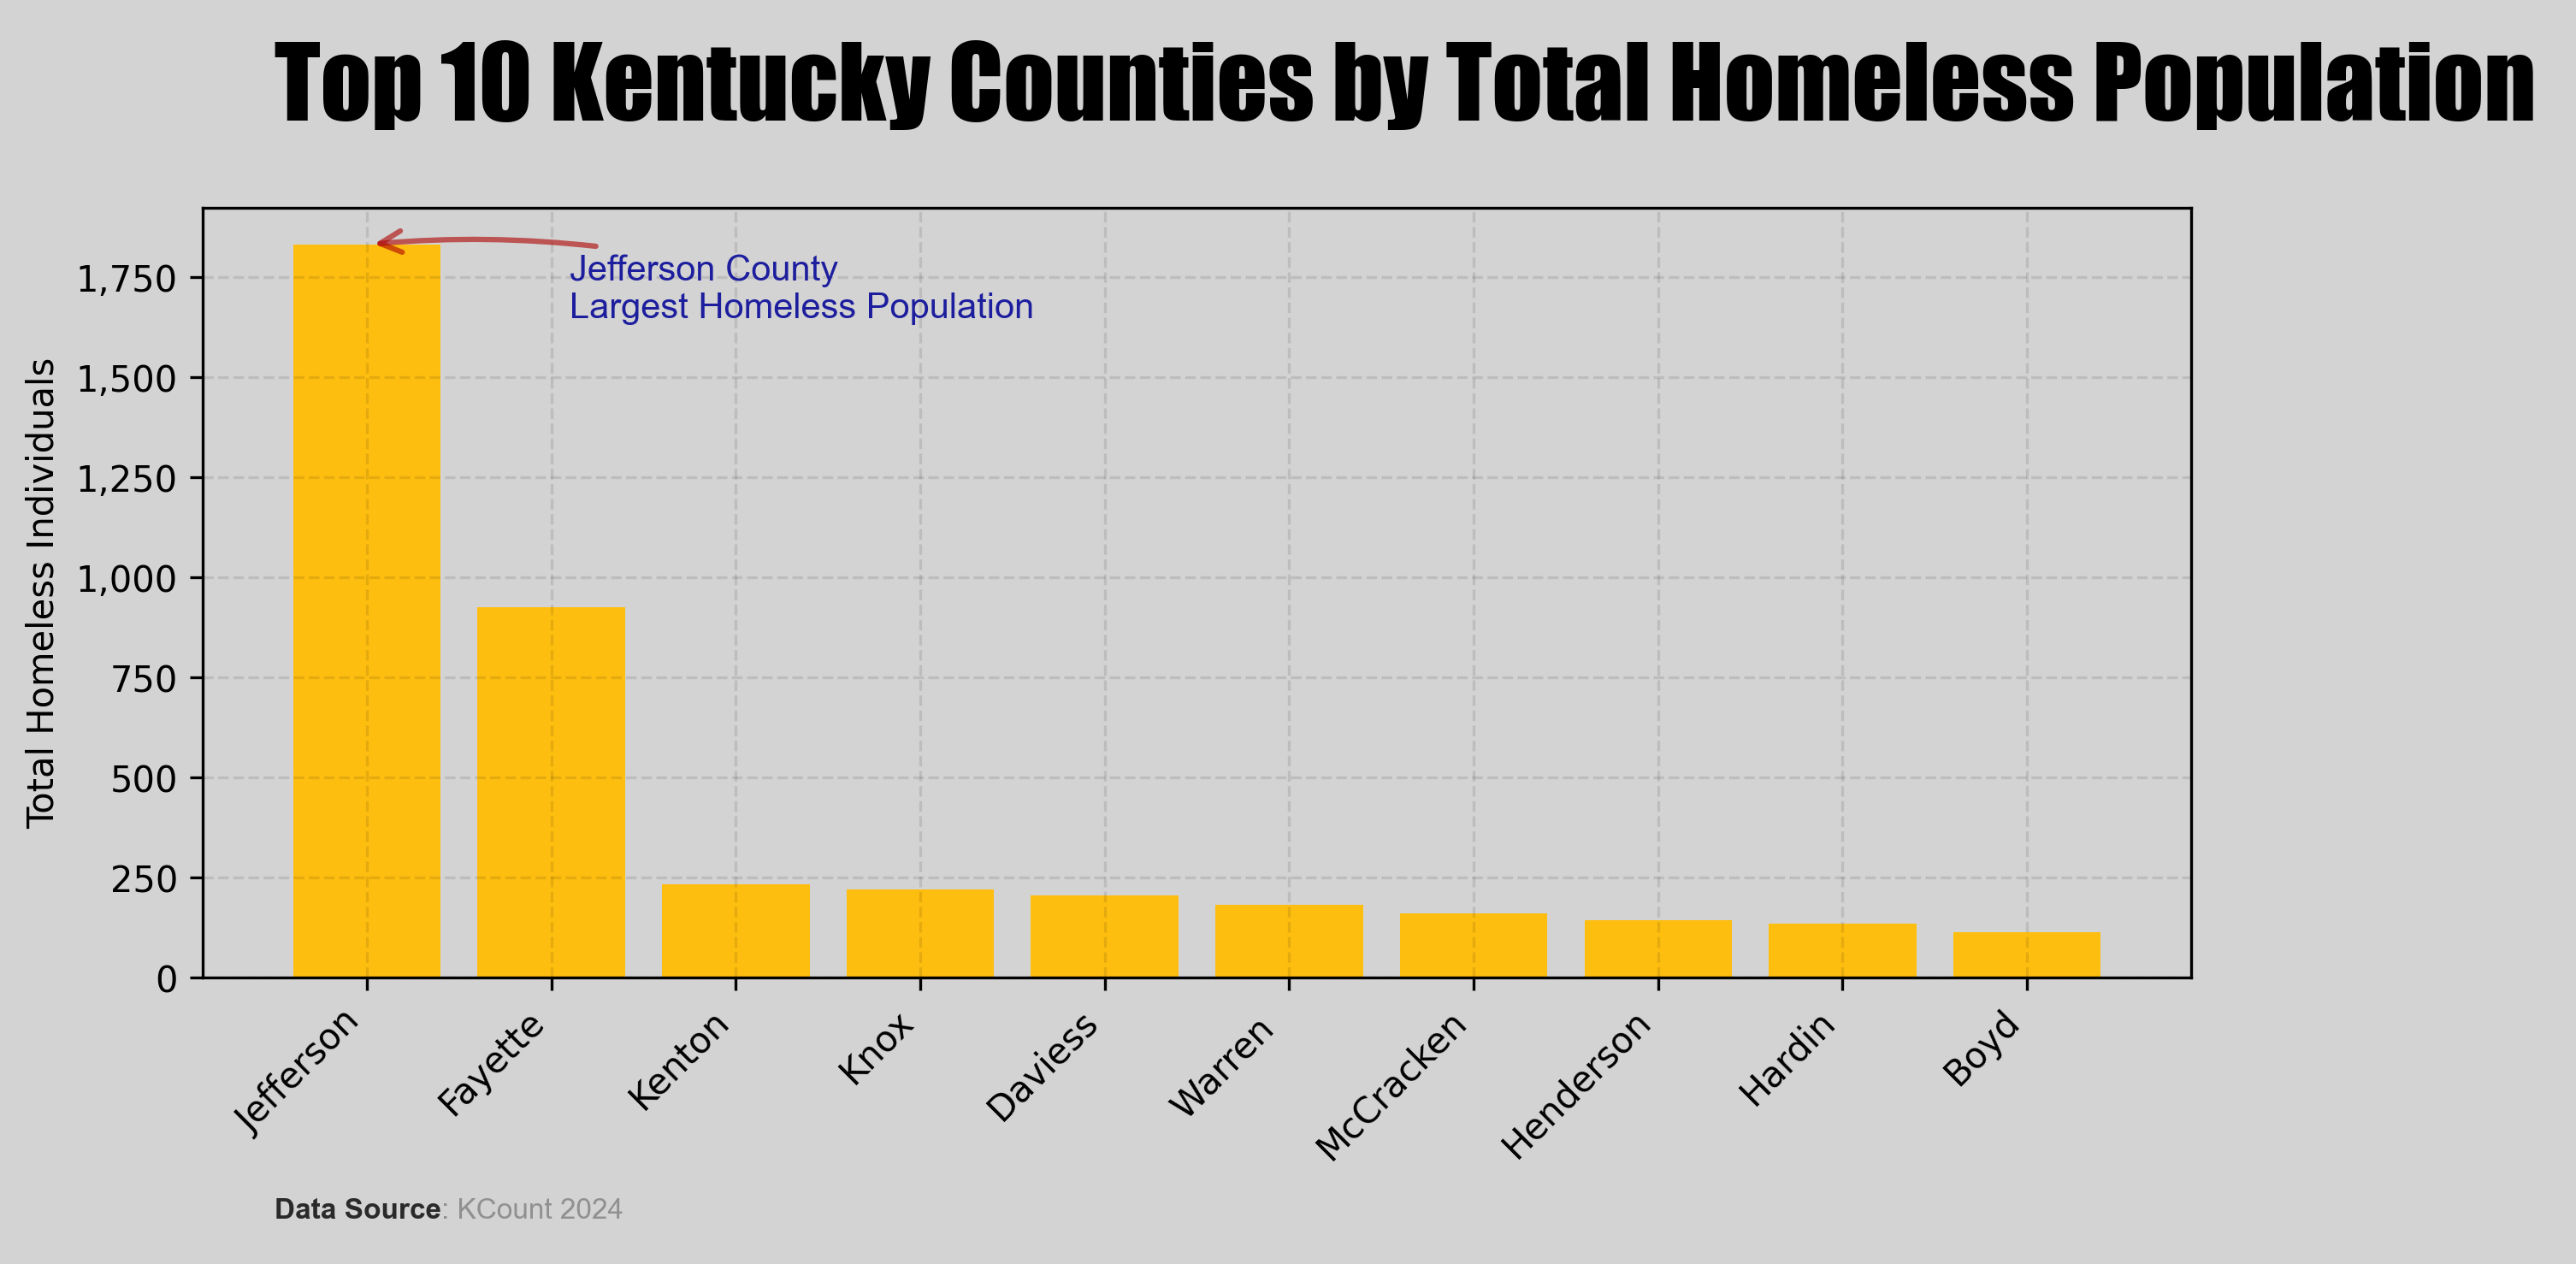

In [10]:
plot_top10_counties(kcount_df)

## Subgroups Within the Homeless Population

In [8]:
def plot_homeless_subgroups(df: pd.DataFrame, output_path: str = "../ashley/plots/homeless_subgroups_stackedbar.png") -> None:
    """
    Plot the composition of homeless subgroups (veterans, chronic, mental illness, etc.)
    for the top 10 Kentucky counties by total homelessness.

    Args:
        df (pd.DataFrame): Cleaned KCount DataFrame containing subgroup columns.
        output_path (str): Path to save the PNG file.

    Returns:
        None. Saves and displays a stacked bar plot.
    """

    # Validate required columns
    required_cols = {
        "county", "total_homeless", "veterans", "chronically_homeless",
        "serious_mental_illness", "substance_use_disorder", "hiv_aids", "domestic_violence"
    }
    missing = required_cols - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    # Set up style
    colors = ['#FEBE10', '#1D1E9E', '#AD0000', '#000000', '#FFFFFF']
    plt.rcParams.update({
        'axes.prop_cycle': cycler('color', colors),
        'figure.facecolor': 'lightgrey',
        'axes.facecolor': 'lightgrey',
        'axes.grid': True,
        'grid.color': '#000000',
        'grid.alpha': 0.1,
        'grid.linestyle': '--',
        'font.family': 'DejaVu Sans',
        'text.color': '#000000',
        'axes.labelcolor': '#000000',
        'axes.edgecolor': '#000000'
    })

    # Define numeric axis formatter
    formatter = mticker.StrMethodFormatter("{x:,.0f}")

    def _is_number(s):
        try:
            float(s.replace(',', ''))
            return True
        except ValueError:
            return False

    def apply_formatter(ax=None):
        if ax is None:
            ax = plt.gca()
        x_labels = [lbl.get_text() for lbl in ax.get_xticklabels()]
        y_labels = [lbl.get_text() for lbl in ax.get_yticklabels()]
        if all(_is_number(lbl) for lbl in x_labels):
            ax.xaxis.set_major_formatter(formatter)
        if all(_is_number(lbl) for lbl in y_labels):
            ax.yaxis.set_major_formatter(formatter)

    # Data prep
    sub_cols = [
        "veterans", "chronically_homeless", "serious_mental_illness",
        "substance_use_disorder", "hiv_aids", "domestic_violence"
    ]

    kcount_top10 = (
        df.sort_values("total_homeless", ascending=False)
        .head(10)
        .reset_index(drop=True)
    )

    # Stacked bar chart
    plt.figure(figsize=(10, 6), dpi=300)
    ax = plt.gca()
    bottom_vals = np.zeros(len(kcount_top10))

    for color, subgroup in zip(colors[:len(sub_cols)], sub_cols):
        values = kcount_top10[subgroup]
        plt.bar(
            kcount_top10["county"],
            values,
            bottom=bottom_vals,
            label=subgroup.replace("_", " ").title(),
            color=color
        )
        bottom_vals += values

    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Individuals Reported")
    plt.xlabel("County")

    # Title & subtitle
    y_max = (kcount_top10[sub_cols].sum(axis=1)).max()
    s = "Composition of Homeless Population by Subgroup (Top 10 Counties)"
    ax_text(x=-0.5, y=y_max * 1.30, s=s, fontfamily='impact', size=24, ha="left")

    subtitle = (
        "Subgroup composition varies widely across counties,\n"
        "highlighting differences in veteran status, chronic homelessness, and health factors."
    )
    ax_text(x=-0.5, y=y_max * 1.15, s=subtitle, fontfamily='arial', size=10, ha="left", color="#AD0000", alpha=0.8)

    # Jefferson County annotation
    jefferson_row = kcount_top10[kcount_top10["county"].str.contains("Jefferson", case=False, na=False)]
    if not jefferson_row.empty:
        jx = jefferson_row.index[0]
        jy = jefferson_row[sub_cols].sum(axis=1).values[0]
        ax.annotate(
            "Jefferson County\nLargest Overall Count",
            xy=(jx, jy),
            xytext=(jx + 0.8, jy * 0.8),
            ha="left",
            fontsize=10,
            fontfamily='Arial',
            color="#1D1E9E",
            arrowprops=dict(
                arrowstyle="->",
                color="#AD0000",
                lw=1.5,
                mutation_scale=15,
                connectionstyle="arc3,rad=0.1",
                alpha=0.6,
            ),
        )

    # Caption & legend
    s = "<Data Source>: KCount 2024"
    ax_text(x=-0.5, y=-y_max * 0.30, s=s, fontfamily='Arial', size=8, color='grey', ha="left", alpha=0.8,
            highlight_textprops=[{"weight": "bold", "color": "black"}])
    plt.legend(title="Subgroup", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Final formatting, save, and show
    apply_formatter()
    plt.subplots_adjust(top=0.78, bottom=0.28, right=0.80)
    plt.savefig(output_path, dpi=300, bbox_inches="tight", facecolor=plt.gcf().get_facecolor())
    plt.show()


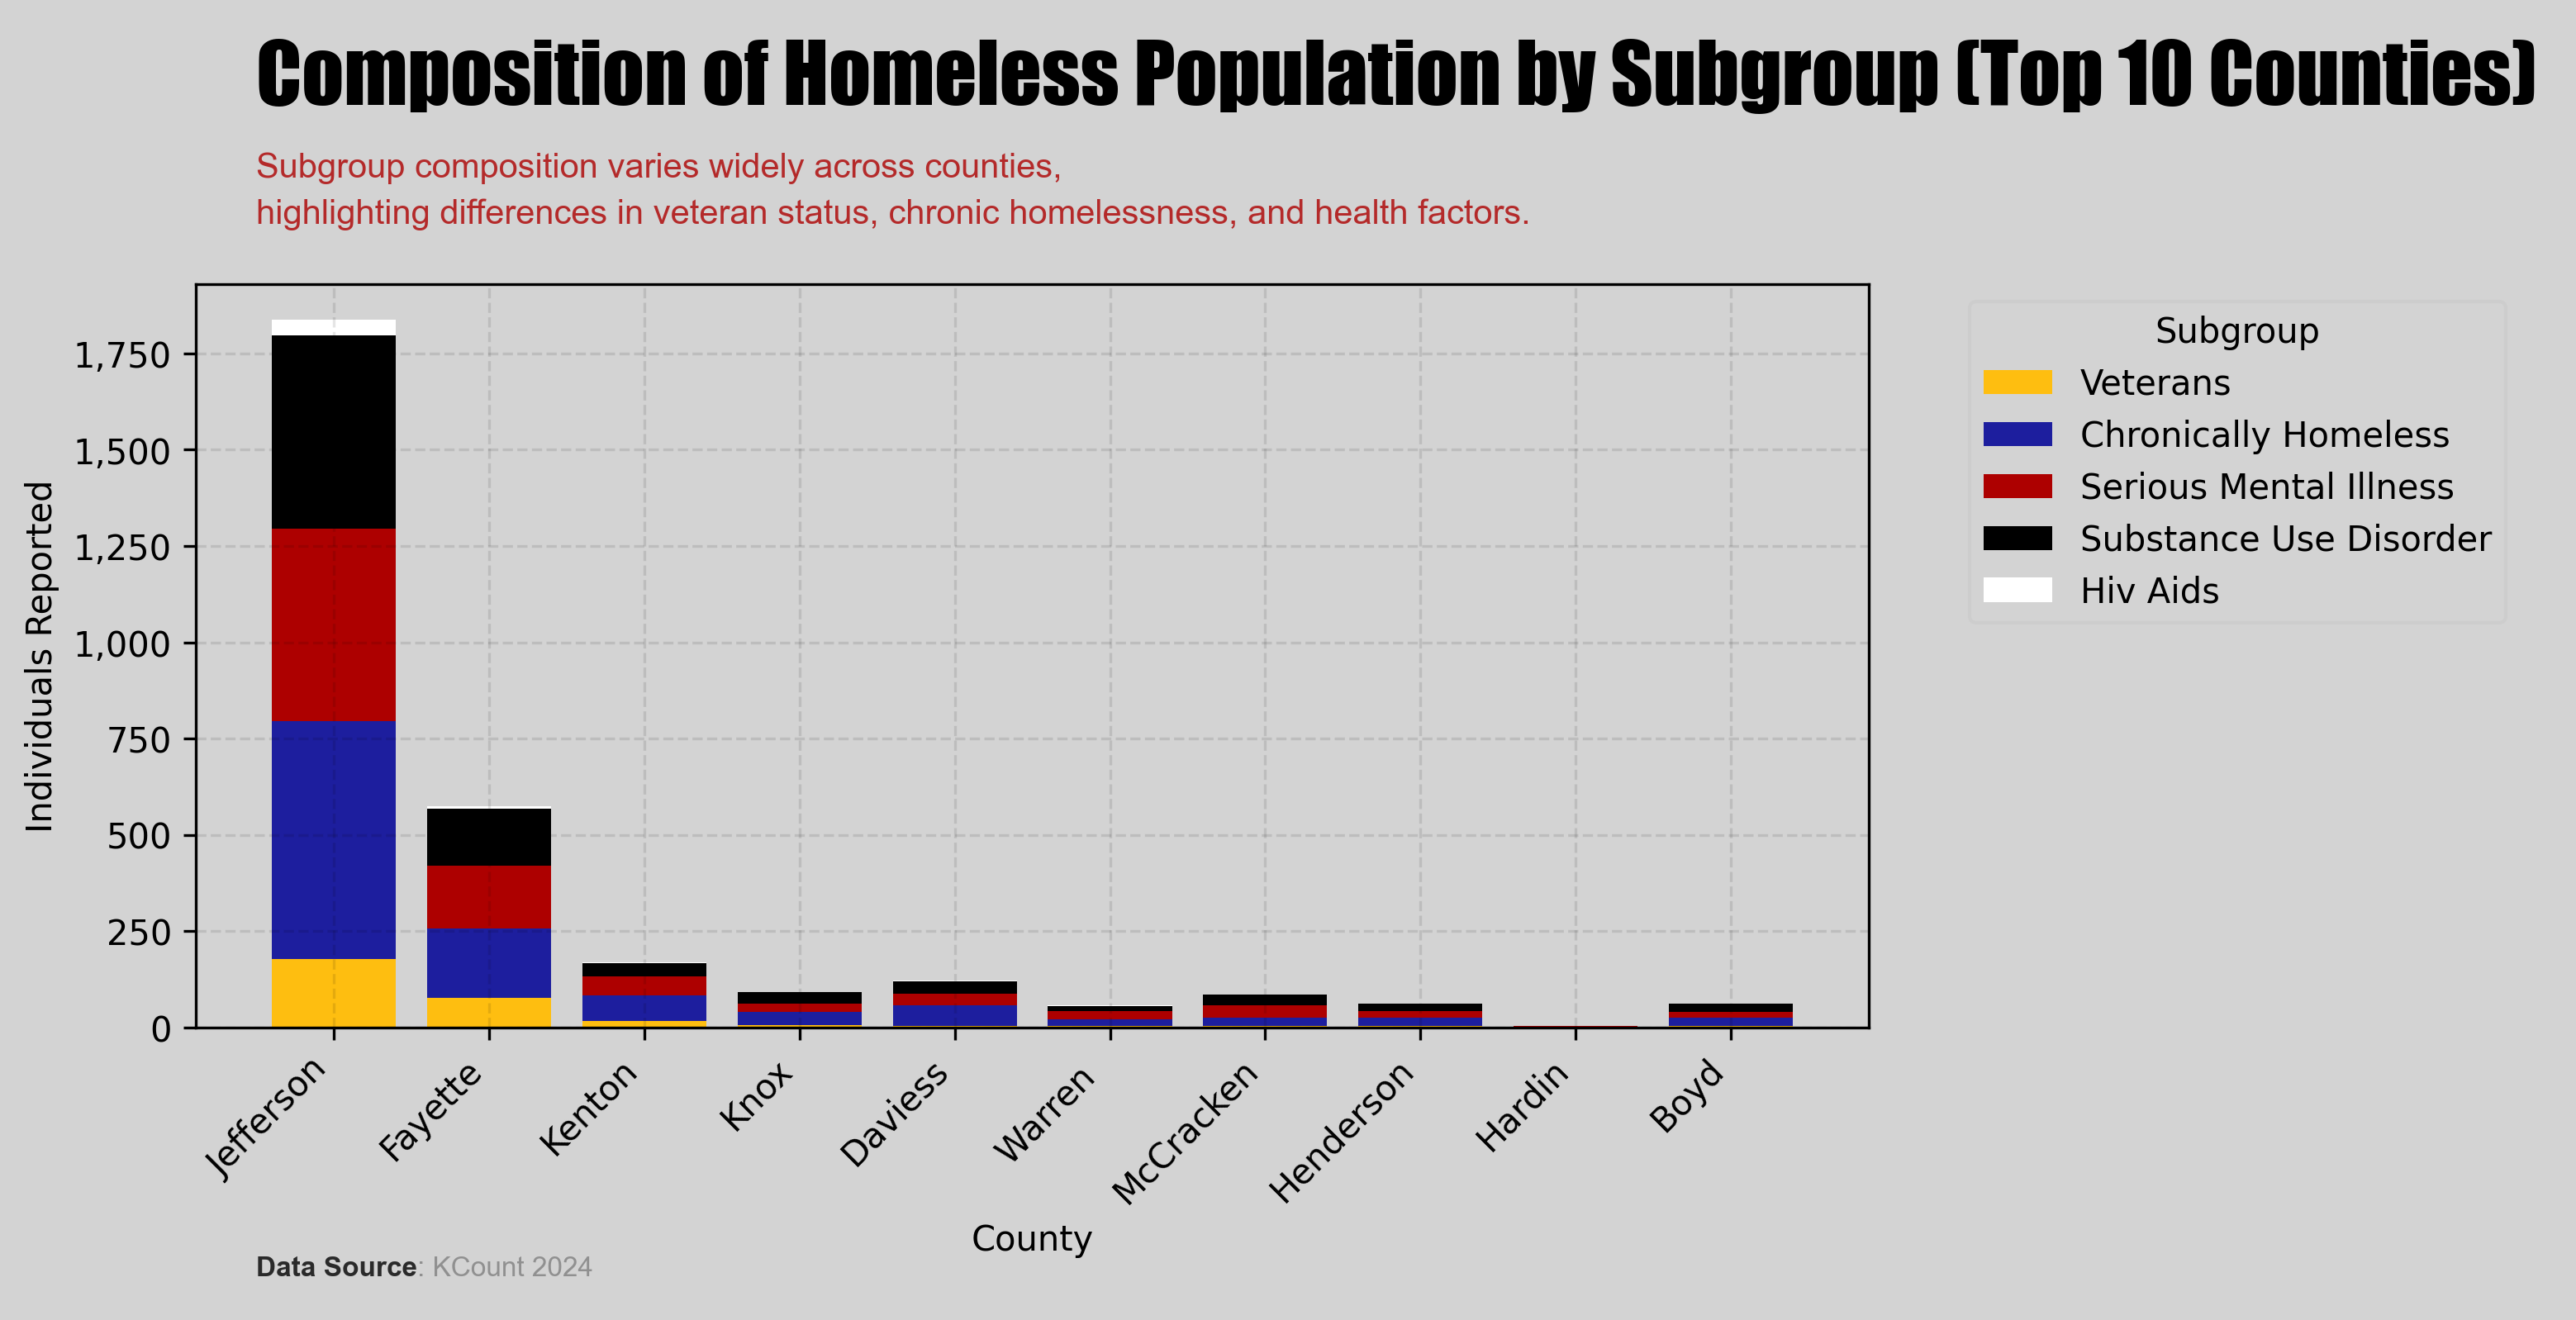

In [9]:
plot_homeless_subgroups(kcount_df)

# Main Execution

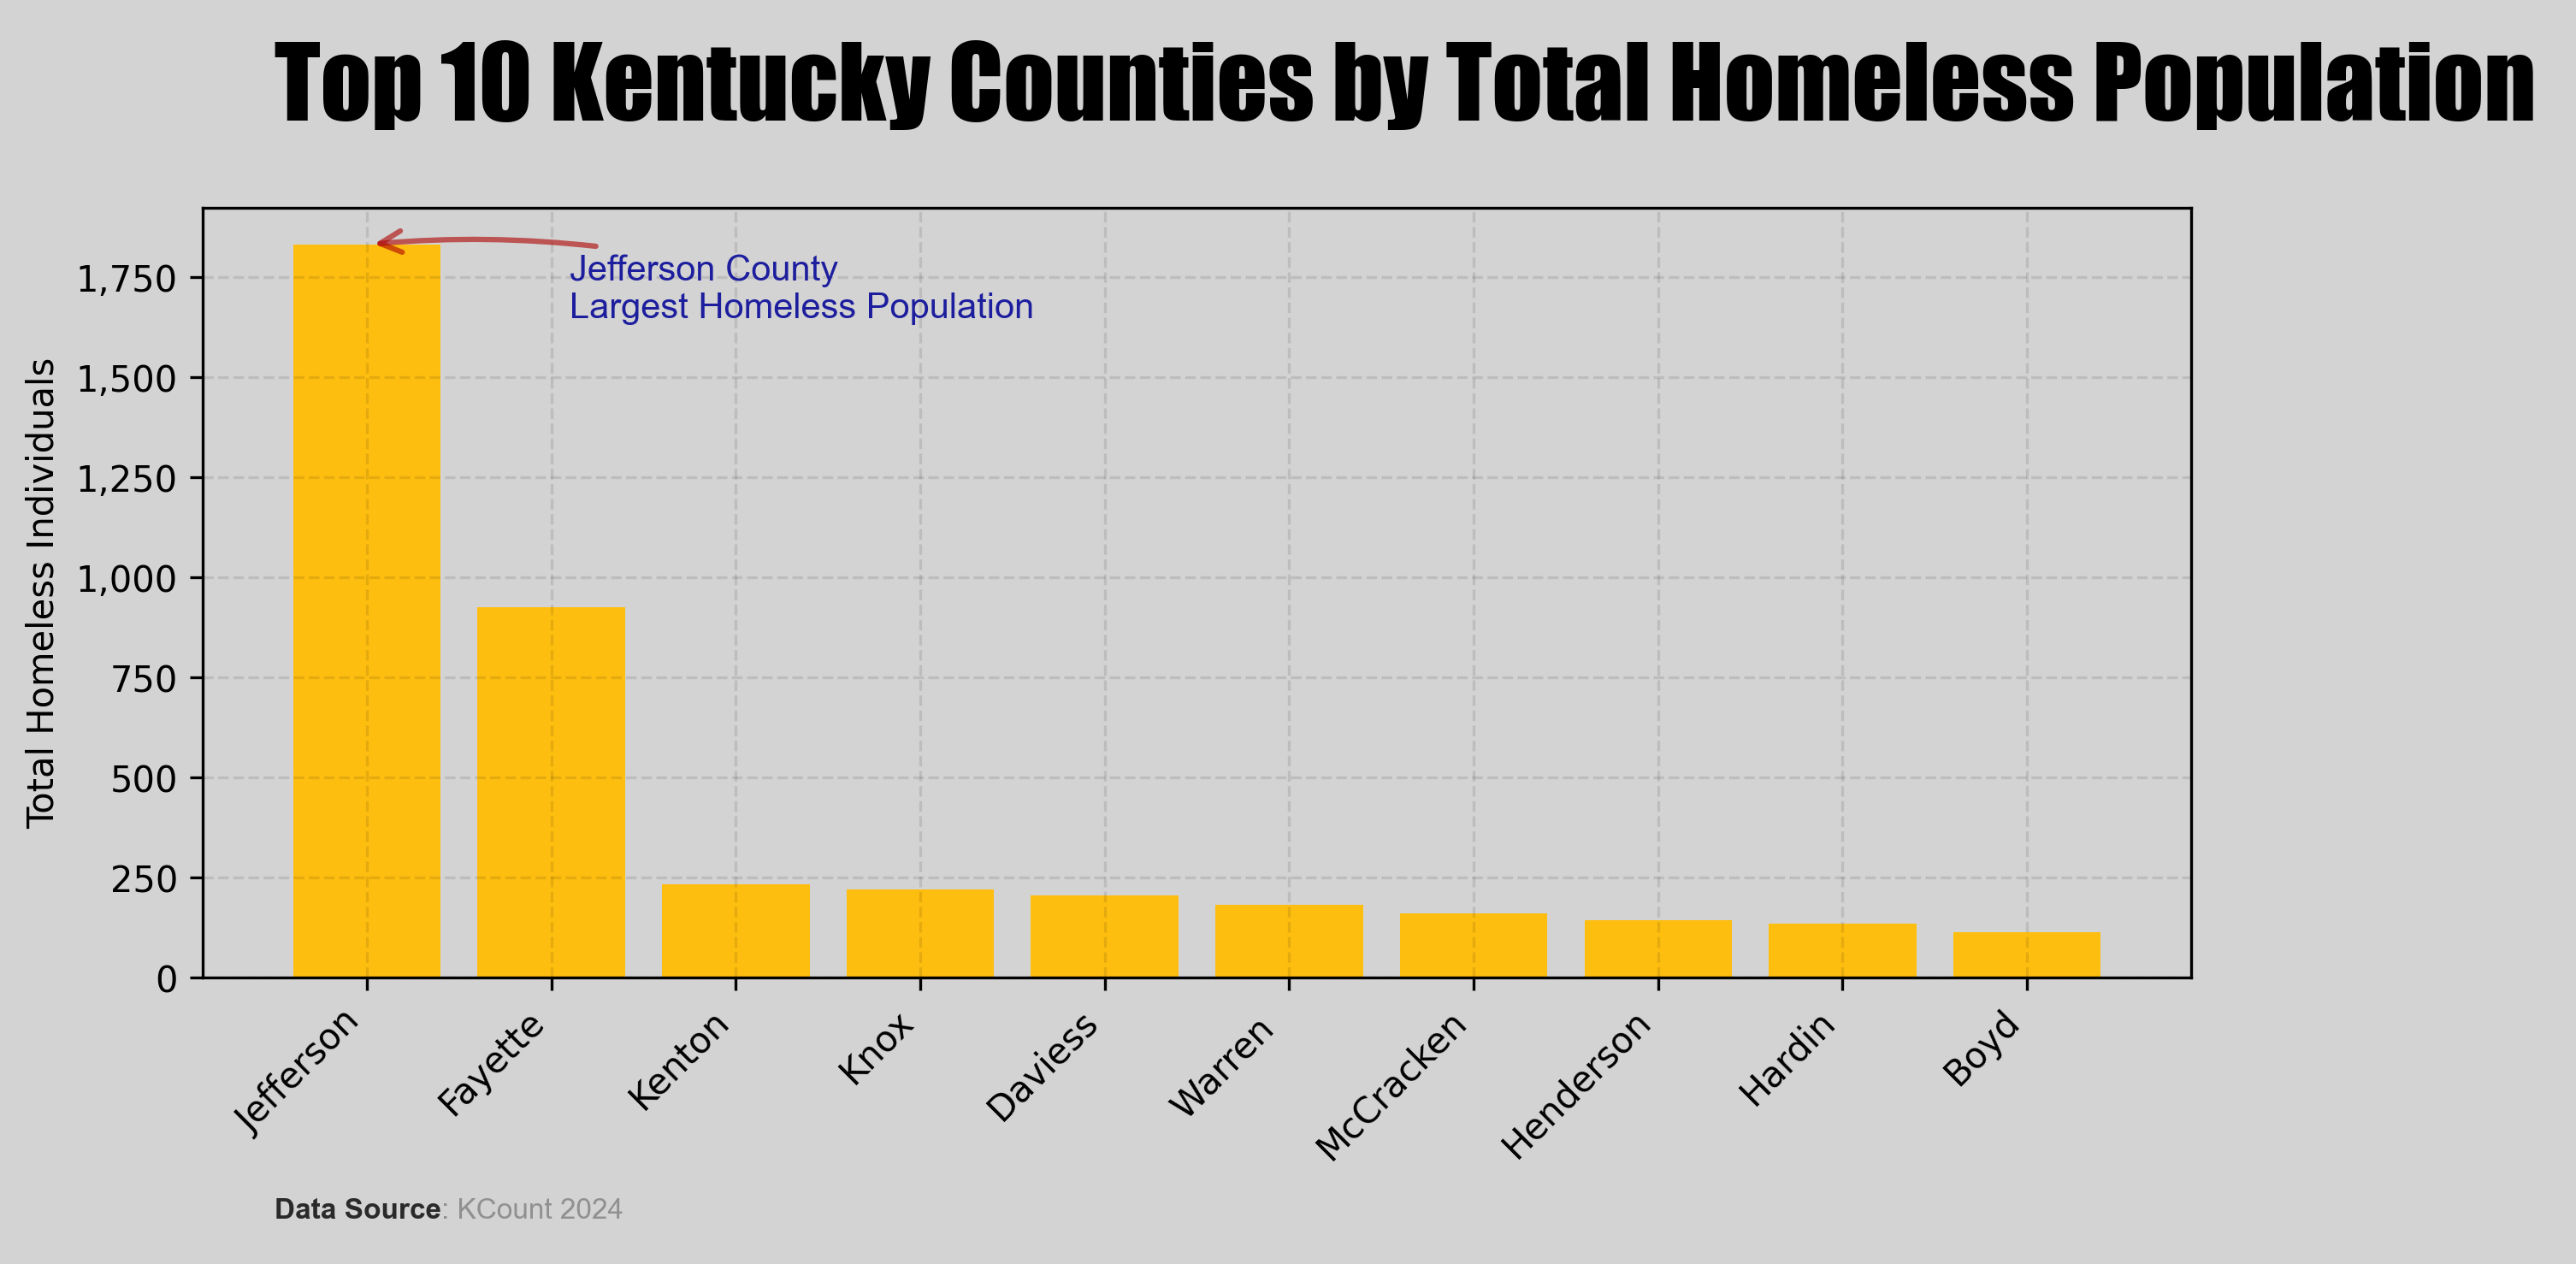

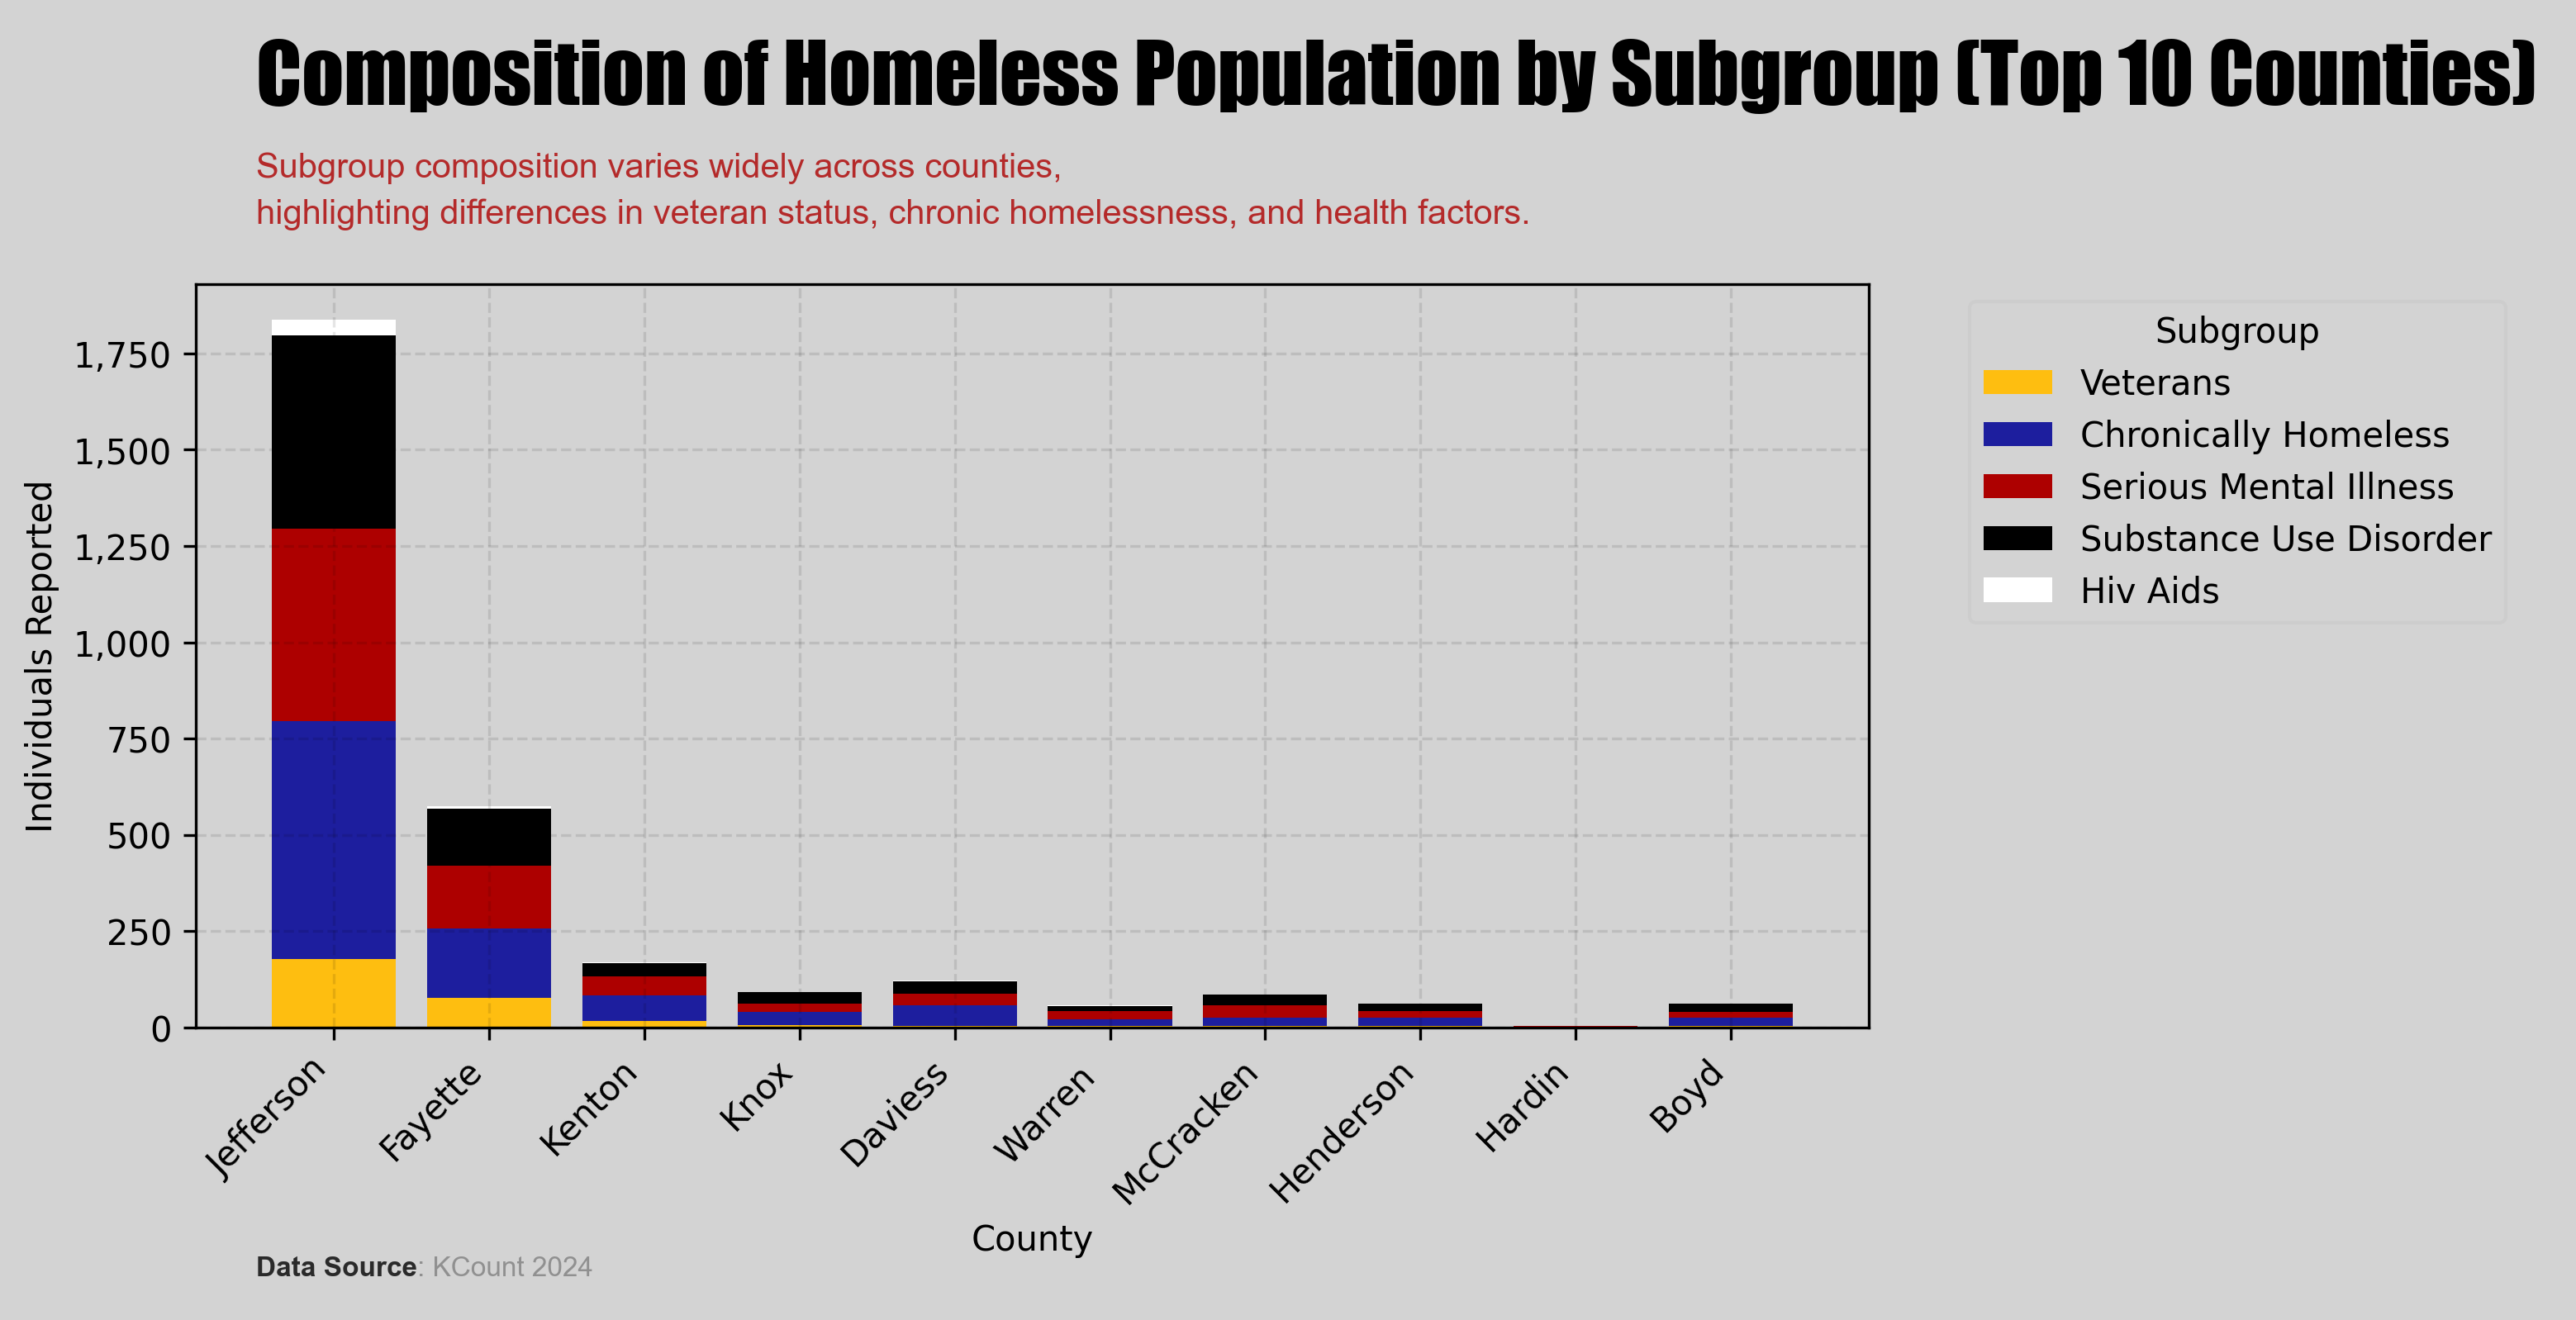

In [11]:
if __name__ == "__main__":
    # --- Read data ---
    kcount_df = read_kcount("../ashley/data/k_count.xlsx")
    hud_df = read_hud("../ashley/data/hud.xlsx")

    # --- Generate plots ---
    plot_top10_counties(kcount_df)
    plot_homeless_subgroups(kcount_df)


# Keep this file in your project

keep at the bottom of your project

We will go over it later, its a script that will generate a markdown table of contents based on your headings created here in markdown.

In [12]:
import json
import os


def generate_toc_from_notebook(notebook_path):
    """
    Parses a local .ipynb file and generates Markdown for a Table of Contents.
    """
    if not os.path.isfile(notebook_path):
        print(f"❌ Error: File not found at '{notebook_path}'")
        return

    with open(notebook_path, 'r', encoding='utf-8') as f:
        notebook = json.load(f)

    toc_markdown = "### **Table of Contents**\n"
    for cell in notebook.get('cells', []):
        if cell.get('cell_type') == 'markdown':
            for line in cell.get('source', []):
                if line.strip().startswith('#'):
                    level = line.count('#')
                    title = line.strip('#').strip()
                    link = title.lower().replace(' ', '-').strip('-.()')
                    indent = '  ' * (level - 1)
                    toc_markdown += f"{indent}* [{title}](#{link})\n"

    print("\n--- ✅ Copy the Markdown below and paste"
          "it into a new markdown cell ---\n")
    print(toc_markdown)


if __name__ == "__main__":
    # Example usage
    notebook_path = 'ashley.ipynb'  # Replace with your notebook path
    generate_toc_from_notebook(notebook_path)


--- ✅ Copy the Markdown below and pasteit into a new markdown cell ---

### **Table of Contents**
    * [**Table of Contents**](#**table-of-contents**)
* [Error Handling](#error-handling)
* [Exploration and Cleaning](#exploration-and-cleaning)
  * [EDA Function](#eda-function)
  * [K Count](#k-count)
  * [HUD](#hud)
* [Plots](#plots)
  * [Functions](#functions)
  * [Highest Homeless Population by County](#highest-homeless-population-by-county)
  * [Subgroups Within the Homeless Population](#subgroups-within-the-homeless-population)
* [Keep this file in your project](#keep-this-file-in-your-project)

